<a href="https://colab.research.google.com/github/AbdurRafiq/Medicare-Fraud-Detection-by-Data-Science/blob/master/Unsupervisedfrauddetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import math
import random
%matplotlib inline
import random
from matplotlib import pyplot


In [3]:
df = pd.read_csv("/content/drive/My Drive/content/gdrive/rafiq/provider.csv")
df.head()

,npi,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt,FRAUD
0,1003127655,617.0,499,617,219.944716,332.463533,170.918590,160.501297,1
1,1003127655,249.0,17,249,42.570080,69.899598,33.024418,30.899317,1
2,1003127655,1220.0,235,1220,78.414213,120.000000,61.340197,57.327828,1
3,1003127655,754.0,434,754,113.284987,172.590186,88.611313,83.092427,1
4,1003127655,543.0,448,543,117.852320,188.176796,91.907495,85.472413,1


In [0]:
df.FRAUD.value_counts()

0    97950
1     2050
Name: FRAUD, dtype: int64

In [5]:
df.describe(include="all")

,npi,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt,FRAUD
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.982043e+09,225.783860,77.410920,126.992530,101.561862,341.226581,77.346709,78.226611,0.020500
std,8.012901e+07,2734.932123,219.168965,580.038118,259.505840,963.617769,201.420748,203.838393,0.141704
min,1.003128e+09,11.000000,11.000000,11.000000,0.010000,0.010000,0.000000,0.005833,0.000000
25%,1.992711e+09,21.000000,17.000000,20.000000,24.540000,58.000000,19.587147,20.270000,0.000000
50%,1.992769e+09,43.000000,32.000000,40.000000,65.985000,146.971239,47.268341,48.050000,0.000000
75%,1.992843e+09,118.000000,75.000000,107.000000,113.880000,300.000000,85.495226,85.424484,0.000000
max,1.993000e+09,564499.000000,14311.000000,91429.000000,24126.350000,75344.925926,18915.060000,17413.970000,1.000000


In [6]:
df.corr()

,npi,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt,FRAUD
npi,1.000000,-0.035491,-0.048094,-0.066902,0.004711,0.011544,0.006124,0.005546,-0.867419
line_srvc_cnt,-0.035491,1.000000,0.367888,0.572856,-0.016592,-0.017586,-0.016341,-0.016397,0.029591
bene_unique_cnt,-0.048094,0.367888,1.000000,0.784398,-0.021670,-0.030630,-0.021689,-0.021977,0.037416
bene_day_srvc_cnt,-0.066902,0.572856,0.784398,1.000000,-0.020732,-0.028593,-0.020812,-0.020924,0.055469
average_Medicare_allowed_amt,0.004711,-0.016592,-0.021670,-0.020732,1.000000,0.779159,0.998716,0.996019,-0.002412
average_submitted_chrg_amt,0.011544,-0.017586,-0.030630,-0.028593,0.779159,1.000000,0.779569,0.771432,-0.013459
average_Medicare_payment_amt,0.006124,-0.016341,-0.021689,-0.020812,0.998716,0.779569,1.000000,0.995762,-0.004162
average_Medicare_standard_amt,0.005546,-0.016397,-0.021977,-0.020924,0.996019,0.771432,0.995762,1.000000,-0.003535
FRAUD,-0.867419,0.029591,0.037416,0.055469,-0.002412,-0.013459,-0.004162,-0.003535,1.000000


In [0]:
class ExNode:
    def __init__(self,size):
        self.size=size
        
class InNode:
    def __init__(self,left,right,splitAtt,splitVal):
        self.left=left
        self.right=right
        self.splitAtt=splitAtt
        self.splitVal=splitVal

In [0]:
def iForest(X,noOfTrees,sampleSize):
    forest=[]
    hlim=math.ceil(math.log(sampleSize,2))
    for i in range(noOfTrees):
        X_train=X.sample(sampleSize)
        forest.append(iTree(X_train,0,hlim))
    return forest

In [0]:
def iTree(X,currHeight,hlim):
    if currHeight>=hlim or len(X)<=1:
        return ExNode(len(X))
    else:
        Q=X.columns
        q=random.choice(Q)
        p=random.choice(X[q].unique())
        X_l=X[X[q]<p]
        X_r=X[X[q]>=p]
        return InNode(iTree(X_l,currHeight+1,hlim),iTree(X_r,currHeight+1,hlim),q,p)

In [0]:
def pathLength(x,Tree,currHeight):
    if isinstance(Tree,ExNode):
        return currHeight
    a=Tree.splitAtt
    if x[a]<Tree.splitVal:
        return pathLength(x,Tree.left,currHeight+1)
    else:
        return pathLength(x,Tree.right,currHeight+1)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
npi                              100000 non-null int64
line_srvc_cnt                    100000 non-null float64
bene_unique_cnt                  100000 non-null int64
bene_day_srvc_cnt                100000 non-null int64
average_Medicare_allowed_amt     100000 non-null float64
average_submitted_chrg_amt       100000 non-null float64
average_Medicare_payment_amt     100000 non-null float64
average_Medicare_standard_amt    100000 non-null float64
FRAUD                            100000 non-null int64
dtypes: float64(5), int64(4)
memory usage: 6.9 MB


In [11]:
df.dtypes

npi                                int64
line_srvc_cnt                    float64
bene_unique_cnt                    int64
bene_day_srvc_cnt                  int64
average_Medicare_allowed_amt     float64
average_submitted_chrg_amt       float64
average_Medicare_payment_amt     float64
average_Medicare_standard_amt    float64
FRAUD                              int64
dtype: object

In [0]:
y_true=df['FRAUD']
df_data=df.drop('FRAUD',1)

In [0]:
sampleSize=50000
ifor=iForest(df_data.sample(100000),100,sampleSize) ##Forest of 100 trees

In [0]:
posLenLst=[]
negLenLst=[]

for sim in range(50000):
    ind=random.choice(df_data[y_true==1].index)
    for tree in ifor:
        posLenLst.append(pathLength(df_data.iloc[ind],tree,0))
        
    ind=random.choice(df_data[y_true==0].index)
    for tree in ifor:
        negLenLst.append(pathLength(df_data.iloc[ind],tree,0))

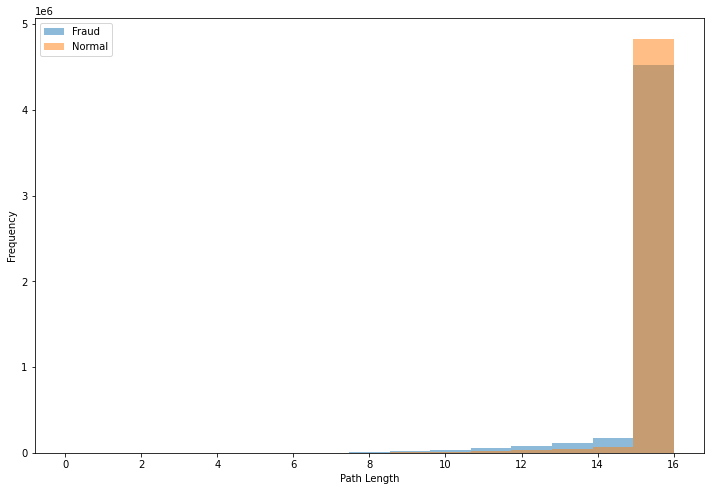

In [0]:
bins = np.linspace(0,math.ceil(math.log(sampleSize,2)), math.ceil(math.log(sampleSize,2)))

pyplot.figure(figsize=(12,8))
pyplot.hist(posLenLst, bins, alpha=0.5, label='Fraud')
pyplot.hist(negLenLst, bins, alpha=0.5, label='Normal')
pyplot.xlabel('Path Length')
pyplot.ylabel('Frequency')
pyplot.legend(loc='upper left')

In [0]:
from sklearn.manifold import TSNE

In [0]:
df_plt=df[df['FRAUD']==0].sample(2000)
df_plt_pos=df[df['FRAUD']==1].sample(400)
df_plt=pd.concat([df_plt,df_plt_pos])
y_plt=df_plt['FRAUD']
X_plt=df_plt.drop('FRAUD',1)

In [0]:
X_embedded = TSNE(n_components=2).fit_transform(X_plt)

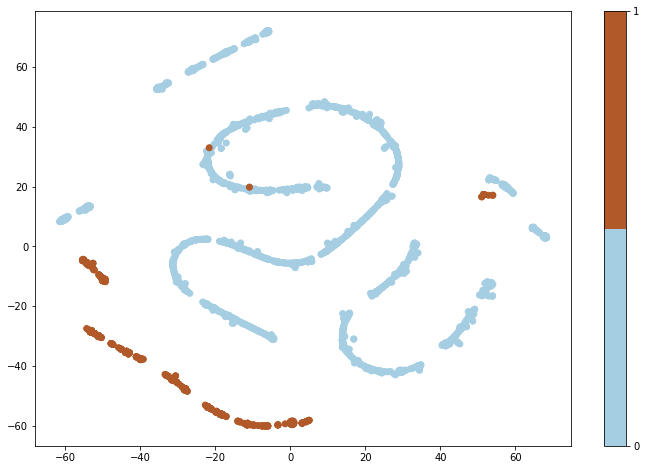

In [0]:
pyplot.figure(figsize=(12,8))
pyplot.scatter(X_embedded[:,0], X_embedded[:,1], c=y_plt, cmap=pyplot.cm.get_cmap("Paired", 2))
pyplot.colorbar(ticks=range(2))

In [0]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor ## Only available with scikit-learn 0.19 and later
from sklearn.cluster import KMeans

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df_data, y_true, test_size=0.5, random_state=42)

In [0]:
def preprocess(df_data):
    for col in df_data:
        df_data[col]=(df_data[col]-np.min(df_data[col]))/(np.max(df_data[col])-np.min(df_data[col]))
    return

In [0]:
def train(X,clf,ensembleSize=5,sampleSize=50000):
    mdlLst=[]
    for n in range(ensembleSize):
        X=df_data.sample(sampleSize)
        clf.fit(X)
        mdlLst.append(clf)
    return mdlLst

In [0]:
## Not valif for LOF
def predict(X,mdlLst):
    y_pred=np.zeros(X.shape[0])
    for clf in mdlLst:
        y_pred=np.add(y_pred,clf.decision_function(X).reshape(X.shape[0],))
    y_pred=(y_pred*1.0)/len(mdlLst)
    return y_pred

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix,f1_score

In [0]:
alg=IsolationForest(n_estimators=100, max_samples='auto', contamination=0.01, \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0,behaviour="new")

In [0]:
%%timeit
if_mdlLst=train(X_train,alg)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You shoul

1 loop, best of 3: 8.26 s per loop


In [0]:
if_mdlLst=train(X_train,alg)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You shoul

In [0]:
%%timeit
if_y_pred=predict(X_test,if_mdlLst)
if_y_pred=1-if_y_pred

#Creating class labels based on decision function
if_y_pred_class=if_y_pred.copy()
if_y_pred_class[if_y_pred>=np.percentile(if_y_pred,95)]=1
if_y_pred_class[if_y_pred<np.percentile(if_y_pred,95)]=0

1 loop, best of 3: 5.66 s per loop


In [0]:
if_y_pred=predict(X_test,if_mdlLst)
if_y_pred=1-if_y_pred

#Creating class labels based on decision function
if_y_pred_class=if_y_pred.copy()
if_y_pred_class[if_y_pred>=np.percentile(if_y_pred,95)]=1
if_y_pred_class[if_y_pred<np.percentile(if_y_pred,95)]=0

In [0]:
roc_auc_score(y_test, if_y_pred_class)

0.6242638730015602

In [0]:
f1_score(y_test, if_y_pred_class)

0.16833095577746077

In [0]:
if_cm=confusion_matrix(y_test, if_y_pred_class)

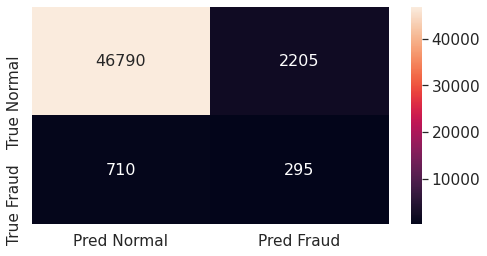

In [0]:
import seaborn as sn
     
df_cm = pd.DataFrame(if_cm,
                  ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
pyplot.figure(figsize = (8,4))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font siz

In [0]:
##Kmeans
kmeans = KMeans(n_clusters=8, random_state=100,n_jobs=-1).fit(X_train)


In [0]:
kmeans = KMeans(n_clusters=20, random_state=42,n_jobs=-1).fit(X_train)

In [0]:
X_test_clusters=kmeans.predict(X_test)
X_test_clusters_centers=kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x,y in zip(X_test.values,X_test_clusters_centers[X_test_clusters])]

km_y_pred=np.array(dist)
km_y_pred[dist>=np.percentile(dist,95)]=1
km_y_pred[dist<np.percentile(dist,95)]=0

In [0]:
X_test_clusters=kmeans.predict(X_test)
X_test_clusters_centers=kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x,y in zip(X_test.values,X_test_clusters_centers[X_test_clusters])]

km_y_pred=np.array(dist)
km_y_pred[dist>=np.percentile(dist,95)]=1
km_y_pred[dist<np.percentile(dist,95)]=0

In [0]:
roc_auc_score(y_test, km_y_pred)

0.962403768482823

In [0]:
f1_score(y_test, km_y_pred)

0.5483594864479315

In [0]:
km_cm=confusion_matrix(y_test, km_y_pred)

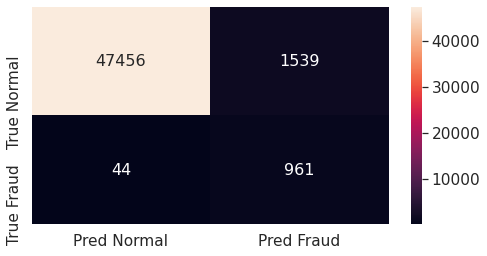

In [0]:
df_cm = pd.DataFrame(km_cm,
                  ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
pyplot.figure(figsize = (8,4))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size

In [0]:
clf=LocalOutlierFactor(n_neighbors=40, algorithm='auto', leaf_size=30, \
                   metric='minkowski', p=2, metric_params=None, contamination=0.5, n_jobs=-1)

In [0]:
%%timeit
clf.fit(X_test)

1 loop, best of 3: 1.02 s per loop


In [0]:
%%timeit
clf.fit(X_test)

1 loop, best of 3: 1.01 s per loop


In [0]:
%%timeit
lof_y_pred=clf.negative_outlier_factor_

#Creating class labels based on decision function
lof_y_pred_class=lof_y_pred.copy()
lof_y_pred_class[lof_y_pred>=np.percentile(lof_y_pred,95)]=1
lof_y_pred_class[lof_y_pred<np.percentile(lof_y_pred,95)]=0

1000 loops, best of 3: 1.55 ms per loop


In [0]:
lof_y_pred=clf.negative_outlier_factor_

#Creating class labels based on decision function
lof_y_pred_class=lof_y_pred.copy()
lof_y_pred_class[lof_y_pred>=np.percentile(lof_y_pred,95)]=1
lof_y_pred_class[lof_y_pred<np.percentile(lof_y_pred,95)]=0

In [0]:
roc_auc_score(y_test, lof_y_pred_class)

0.5196740554803287

In [0]:
f1_score(y_test, lof_y_pred_class)

0.050784593437945794

In [0]:
lof_cm=confusion_matrix(y_test, lof_y_pred_class)

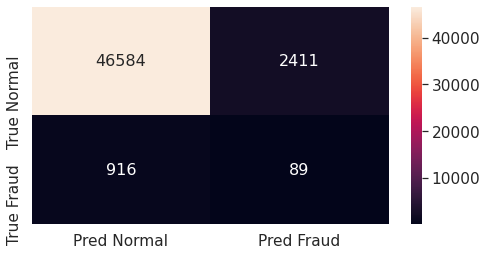

In [0]:
df_cm = pd.DataFrame(lof_cm,
                  ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
pyplot.figure(figsize = (8,4))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size

In [0]:
##one-class
alg=OneClassSVM(kernel='linear',gamma='auto', coef0=0.0, tol=0.001, nu=0.5, \
                shrinking=True, cache_size=500, verbose=False, max_iter=-1)

In [0]:
%%timeit
osvm_mdlLst=train(X_train,alg)

1 loop, best of 3: 4min 5s per loop


In [0]:
osvm_mdlLst=train(X_train,alg)

In [0]:
%%timeit
osvm_y_pred=predict(X_test,osvm_mdlLst)

#Creating class labels based on decision function
osvm_y_pred_class=osvm_y_pred.copy()
osvm_y_pred_class[osvm_y_pred<0]=1
osvm_y_pred_class[osvm_y_pred>=0]=0

1 loop, best of 3: 51.6 s per loop


In [0]:
osvm_y_pred=predict(X_test,osvm_mdlLst)

#Creating class labels based on decision function
osvm_y_pred_class=osvm_y_pred.copy()
osvm_y_pred_class[osvm_y_pred<0]=1
osvm_y_pred_class[osvm_y_pred>=0]=0

In [0]:
roc_auc_score(y_test, osvm_y_pred_class)

0.7544876901338802

In [0]:
f1_score(y_test, osvm_y_pred_class)

0.07717733876547006

In [0]:
osvm_cm=confusion_matrix(y_test, osvm_y_pred_class)

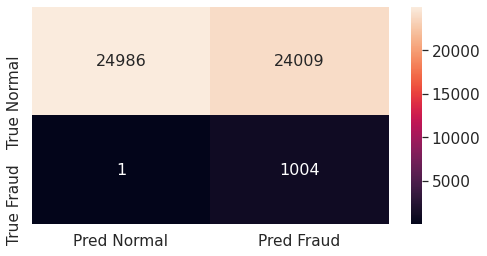

In [0]:
df_cm = pd.DataFrame(osvm_cm,
                  ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
pyplot.figure(figsize = (8,4))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size

In [0]:
auc_scores={
    'Isolation Forest': roc_auc_score(y_test, if_y_pred_class),
    'KMeans':roc_auc_score(y_test, km_y_pred),
    'LOF':roc_auc_score(y_test, lof_y_pred_class),
    'OneClass SVM': roc_auc_score(y_test, osvm_y_pred_class),
    'Autoencoder' : 0.54
}

f1_scores={
    'Isolation Forest':f1_score(y_test, if_y_pred_class),
    'KMeans':f1_score(y_test, km_y_pred),
    'LOF':f1_score(y_test, lof_y_pred_class),
    'OneClass SVM': f1_score(y_test, osvm_y_pred_class)
}

Text(0.5, 0, 'AUC Score')

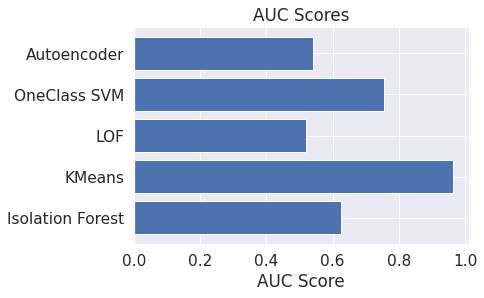

In [0]:
pyplot.title('AUC Scores')
pyplot.barh(range(len(auc_scores)), list(auc_scores.values()), align='center')
pyplot.yticks(range(len(auc_scores)), list(auc_scores.keys()))
pyplot.xlabel('AUC Score')

In [0]:

from sklearn import metrics
import matplotlib.pyplot as plt

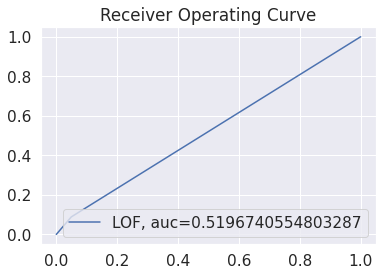

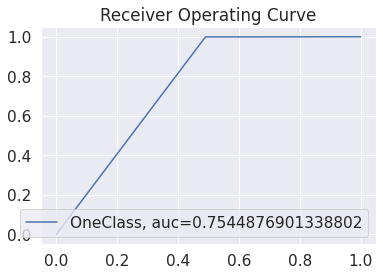

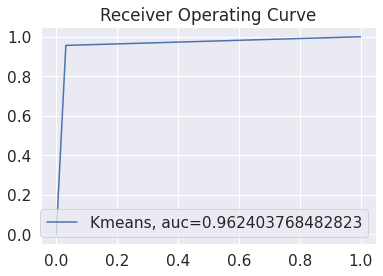

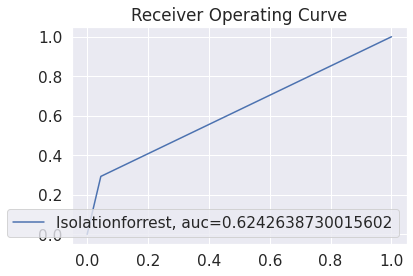

In [0]:


fpr, tpr, _ = metrics.roc_curve(y_test, lof_y_pred_class)
auc = metrics.roc_auc_score(y_test,lof_y_pred_class)
plt.title("Receiver Operating Curve")

plt.plot(fpr,tpr,label="LOF, auc="+str(auc))
plt.legend(loc=4)
plt.show()
fpr, tpr, _ = metrics.roc_curve(y_test, osvm_y_pred_class)
auc = metrics.roc_auc_score(y_test,osvm_y_pred_class)
plt.title("Receiver Operating Curve")

plt.plot(fpr,tpr,label="OneClass, auc="+str(auc))
plt.legend(loc=4)
plt.show()
fpr, tpr, _ = metrics.roc_curve(y_test, km_y_pred)
auc = metrics.roc_auc_score(y_test,km_y_pred)
plt.title("Receiver Operating Curve")

plt.plot(fpr,tpr,label="Kmeans, auc="+str(auc))
plt.legend(loc=4)
plt.show()
fpr, tpr, _ = metrics.roc_curve(y_test, if_y_pred_class
                                )
auc = metrics.roc_auc_score(y_test,if_y_pred_class)
plt.title("Receiver Operating Curve")

plt.plot(fpr,tpr,label="Isolationforrest, auc="+str(auc))
plt.legend(loc=4)
plt.show()